# Object Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
#!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

sh: 1: kill: Usage: kill [-s sigspec | -signum | -sigspec] [pid | job]... or
kill -l [exitstatus]
rm: cannot remove 'nohup.out': No such file or directory
cat: nohup.out: No such file or directory
22/10/22 20:47:15 WARN Utils: Your hostname, William-Shen resolves to a loopback address: 127.0.1.1; using 192.168.56.1 instead (on interface eth1)
22/10/22 20:47:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/10/22 20:47:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
10-22-2022 20:47:20 WARNING[create_udf_executor:create_udf_executor.py:exec:0042] UDF FastRCNNObjectDetector already exists, nothing added.
10-22-2022 20:47:20 WARNING[create_udf_executor:create_udf_executor.py:exe

Note: you may need to restart the kernel to use updated packages.


### Getting the Video Files

In [2]:
# Getting the video files
!wget -nc https://www.dropbox.com/s/kr71gp0h4dzosnk/310_1666117925.mp4
# Getting the FastRCNN object detector
#!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/fastrcnn_object_detector.py
import fastrcnn_object_detector

File ‘310_1666117925.mp4’ already there; not retrieving.



### Load the surveillance videos for analysis

In [3]:
cursor.execute('DROP TABLE ObjectDetectionVideos')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD FILE "310_1666117925.mp4" INTO ObjectDetectionVideos;')
response = cursor.fetch_all()
print(response)

@status: -1
@batch: None
@error: ObjectDetectionVideos does not exist. Create the table using CREATE TABLE.
@status: -1
@batch: None
@error: Video file 310_1666117925.mp4 does not exist.


### Visualize Video

In [6]:
from ipywidgets import Video
Video.from_file("310_1666117925.mp4", embed=True)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x12\xf1moov...')

### Optional - Register FasterRCNN (object detection) model into EVA 

#### Syntax
  
  `CREATE UDF [ IF NOT EXISTS ] <name> 
      INPUT  ( [ <arg_name> <arg_data_type> ] [ , ... ] )
      OUTPUT ( [ <result_name> <result_data_type> ] [ , ... ] )
      TYPE  <udf_type_name>
      IMPL  '<path_to_implementation>'`

#### Required Parameters
`<name>` - specifies the unique identifier for the UDF.

`[ <arg_name> <arg_data_type> ] [ , ... ]` - specifies the name and data type of the udf input arguments. Name is kept for consistency (ignored by eva right now), arguments data type is required. `ANYDIM` means the shape is inferred at runtime.

`[ <result_name> <result_data_type> ] [ , ... ]` - specifies the name and data type of the udf output arguments. 
Users can access a specific output of the UDF similar to access a column of a table. Eg. `<name>.<result_name>` 

`<udf_type_name>` - specifies the identifier for the type of the UDF. UDFs of the same type are assumed to be interchangeable. They should all have identical input and output arguments. For example, object classification can be one type. 

`<path_to_implementation>` - specifies the path to the implementation class for the UDF

In [8]:
cursor.execute("""CREATE UDF IF NOT EXISTS FastRCNNObjectDetector
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
                scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'fastrcnn_object_detector.py';
      """)
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  UDF FastRCNNObjectDetector successfully added ...
@batch_size: 1
@identifier_column: None
@query_time: 1.3480844000000047


10-22-2022 20:34:56 ERROR [drop_executor:drop_executor.py:exec:0059] Failed to drop TABLE REF:: ( ObjectDetectionVideos SAMPLE FREQUENCY None)
NoneType: None
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████------------------------------------| 28.5% Complete

### Run Object detector on the video

In [6]:
cursor.execute("""SELECT id, FastRCNNObjectDetector(data) 
                  FROM ObjectDetectionVideos 
                  WHERE id < 40""")
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:     objectdetectionvideos.id fastrcnnobjectdetector.labels  \
0                          0                  [bird, bird]   
1                          1            [bird, bird, bird]   
2                          2                  [bird, bird]   
3                          3                  [bird, bird]   
4                          4                  [bird, bird]   
5                          5                  [bird, bird]   
6                          6                  [bird, bird]   
7                          7            [bird, bird, bird]   
8                          8            [bird, bird, bird]   
9                          9            [bird, bird, bird]   
10                        10            [bird, bird, bird]   
11                        11                  [bird, bird]   
12                        12                  [bird, bird]   
13                        13                  [bird, bird]   
14                       

### Visualize output of Object detector on the video

In [1]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['fastrcnnobjectdetector.bboxes', 'fastrcnnobjectdetector.labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                img=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness) 
                # frame label
                cv2.putText(img, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
            video.write(img)

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(img)
                plt.show()
        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

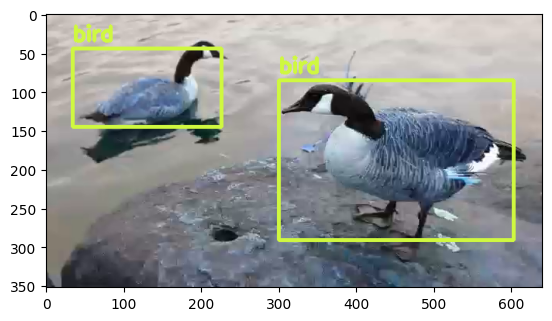

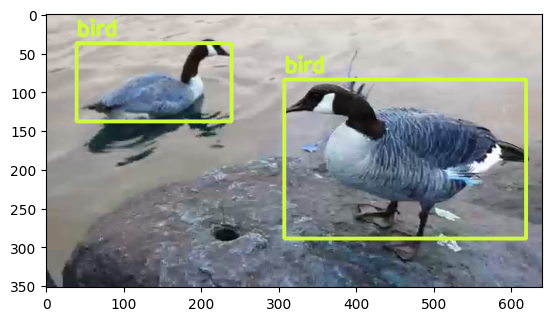

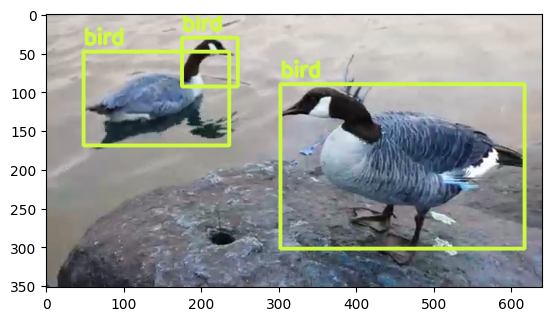

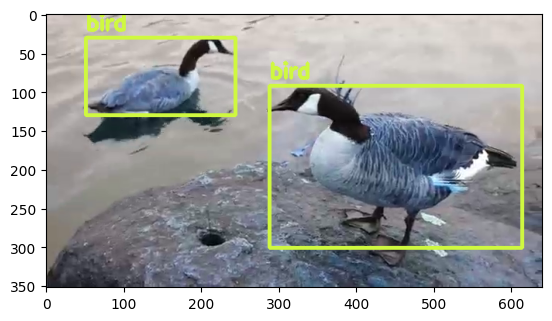

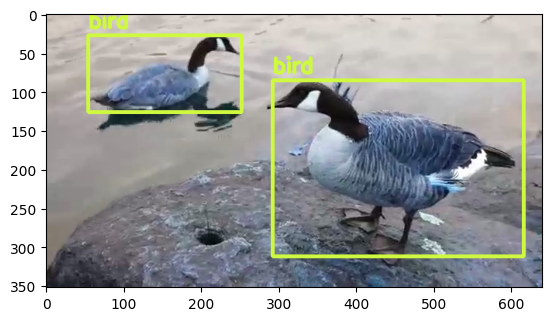

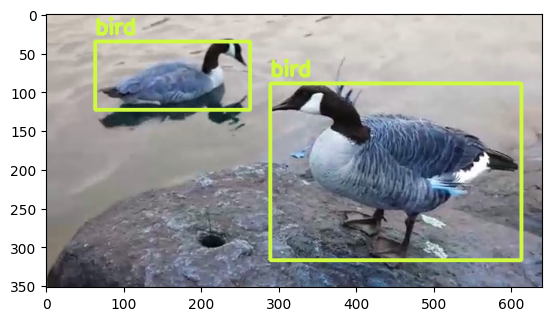

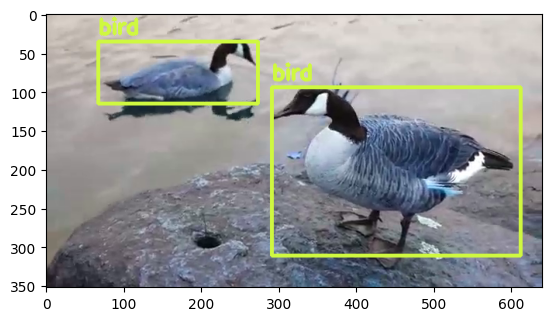

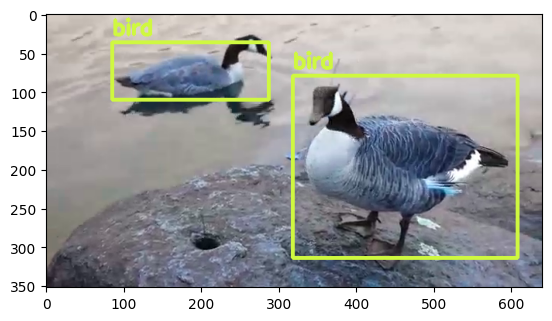

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\te<...')

In [8]:
from ipywidgets import Video, Image
input_path = '310_1666117925.mp4'
output_path = 'video.mp4'

dataframe = response.batch.frames
annotate_video(dataframe, input_path, output_path)
Video.from_file(output_path)

### Dropping a udf
simply enter command `drop udf udf_name`

In [7]:
cursor.execute("DROP UDF FastRCNNObjectDetector;")
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                  0
0  UDF FastRCNNObjectDetector successfully dropped
@batch_size: 1
@identifier_column: None
@query_time: 0.030768399999999474
